In [1]:
%load_ext autotime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

time: 1.86 s (started: 2022-10-06 09:52:30 +08:00)


In [2]:
x = pickle.load(open('./data/fundamentals3.pkl', 'rb'))
y = pickle.load(open('./data/performance3.pkl', 'rb'))

time: 16 ms (started: 2022-10-06 09:52:31 +08:00)


Remember that our data started from Sep 2016 and runs all the way till Sep 2021.

In [3]:
x

,EV_EBIT,OI_NWCFA,PE,PB,PS,OI_IntExp,WorkingCap,ROE,ROCE,DE,DebtRatio,CashRatio,AssetTurnover,GPM,WC_TA,RE_TA,EBIT_TA,Equity_Liab
0,82.797844,0.054971,112.795556,3.347207,12.792295,11.437500,3.846561,0.029675,0.024383,0.835610,2.196731,2.422222,1.738654,0.529253,0.345137,0.781242,0.021427,1.196731
1,73.741818,0.064395,93.220476,3.642102,14.677638,12.875000,3.337925,0.039070,0.030812,0.830698,2.203807,2.057851,1.633997,0.537957,0.323425,-0.057546,0.026550,1.203807
2,85.881068,0.061131,109.984756,4.122857,16.367967,13.400000,3.201348,0.037486,0.030165,0.832229,2.201593,2.012637,1.632593,0.537205,0.325973,-0.049027,0.025699,1.201593
3,93.118058,0.057908,112.367543,4.264654,17.651993,15.461538,3.219984,0.037953,0.029345,0.791585,2.263288,2.065270,1.555866,0.535009,0.333495,-0.031473,0.024936,1.263288
4,89.891130,0.063609,125.146780,4.581382,18.629924,17.923077,3.300871,0.036608,0.033366,0.742709,2.346422,2.120348,1.570674,0.544155,0.344885,-0.014954,0.028365,1.346422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34497,190.226788,0.162071,263.172831,29.454035,41.218524,600.000000,4.955648,0.111919,0.132893,0.363616,3.750153,2.809967,13.838362,0.789181,0.647814,0.552518,0.111129,2.750153
34498,401.544454,0.027134,455.367693,11.194813,30.310853,281.800000,7.889376,0.024584,0.024432,0.198130,6.047194,5.651679,11.991617,0.785479,0.773617,0.333149,0.021689,5.047194
34499,206.724364,0.041892,278.735919,8.760902,19.453274,459.400000,6.229416,0.031431,0.035773,0.269457,4.711162,3.871998,13.301299,0.778988,0.733024,0.324628,0.030759,3.711162
34500,-451.177169,-0.020088,-738.189122,9.281098,21.600759,-120.111111,6.530220,-0.012573,-0.017744,0.250797,4.987290,3.589801,10.494563,0.756041,0.733442,0.323538,-0.015391,3.987290


time: 15 ms (started: 2022-10-06 09:52:31 +08:00)


In [4]:
# Store the target returns temporarily
returns = y['Returns']
returns = returns.astype('float64')

time: 0 ns (started: 2022-10-06 09:52:32 +08:00)


In [5]:
# Add the Returns column to fundamentals data
x['Returns'] = returns

# Drop the null rows and reset index
x = x.dropna(axis=0)
x = x.reset_index(drop=True)

# Randomise the rows for train-test-split
# Specify frac=1 because we want all the rows back
x = x.sample(frac=1, random_state=42)

time: 15 ms (started: 2022-10-06 09:52:32 +08:00)


After randomizing the rows in the x dataframe (with the targets), we want to split back dataset into x and y

In [6]:
x

,EV_EBIT,OI_NWCFA,PE,PB,PS,OI_IntExp,WorkingCap,ROE,ROCE,DE,DebtRatio,CashRatio,AssetTurnover,GPM,WC_TA,RE_TA,EBIT_TA,Equity_Liab,Returns
9512,61.152309,0.011232,242.849305,1.746777,3.294929,1.873373,2.192989,0.007193,0.016495,1.825444,1.547812,0.562642,1.622053,0.298215,0.277082,0.768904,0.012664,0.547812,0.750888
14921,191.444304,0.055181,230.626925,9.566452,42.739314,-600.000000,4.801513,0.041480,0.045186,0.216496,5.619017,2.996542,1.144513,0.636591,0.528882,0.746598,0.038899,4.619017,0.118316
21084,23.341453,0.052044,24.003479,1.905213,4.938724,11.186488,4.820827,0.079372,0.044871,0.470829,3.123914,2.541647,3.084049,0.271395,0.634056,-0.042379,0.037425,2.123914,2.000000
3806,48.709866,0.040933,83.196719,1.997409,3.334102,-600.000000,2.071990,0.024008,0.031880,0.466795,3.142267,0.847927,1.120338,0.603364,0.269438,0.498095,0.023867,2.142267,-0.329577
14240,-119.286254,-0.018351,-115.973861,1.771494,8.553960,-7.463134,0.934720,-0.015275,-0.009852,1.293939,1.772834,0.003624,0.158042,0.021643,-0.003995,0.092568,-0.009249,0.772834,0.261229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,-500.000000,0.017007,-121.882374,1.055749,22.098571,2.068534,0.788793,-0.008662,-0.000447,0.921518,2.085166,0.292856,0.049423,0.759087,-0.007323,0.100303,-0.000432,1.085166,0.152987
5390,68.340866,0.020240,75.999256,2.859115,8.560492,3.055556,0.938080,0.037620,0.016970,3.838145,1.260543,0.062804,0.092861,0.582187,-0.006329,-0.019620,0.015235,0.260543,0.052348
860,-16.971842,-0.038020,-15.913231,0.634586,0.981254,-37.185246,3.073043,-0.039878,-0.036422,0.299700,4.336665,0.054848,1.921880,0.182595,0.478027,0.000000,-0.028023,3.336665,5.005319
15795,-55.388025,-2.090135,-28.933558,7.046389,10.972469,10.051195,0.560037,-0.243537,-0.040507,3.956257,1.252764,0.209345,3.494393,0.510064,-0.063708,0.754257,-0.034642,0.252764,-0.032547


time: 15 ms (started: 2022-10-06 09:52:32 +08:00)


In [7]:
y = x['Returns']
X = x.drop(columns='Returns')

time: 0 ns (started: 2022-10-06 09:52:32 +08:00)


In [8]:
y.head()

9512     0.750888
14921    0.118316
21084    2.000000
3806    -0.329577
14240    0.261229
Name: Returns, dtype: float64

time: 0 ns (started: 2022-10-06 09:52:32 +08:00)


In [9]:
X.head()

,EV_EBIT,OI_NWCFA,PE,PB,PS,OI_IntExp,WorkingCap,ROE,ROCE,DE,DebtRatio,CashRatio,AssetTurnover,GPM,WC_TA,RE_TA,EBIT_TA,Equity_Liab
9512,61.152309,0.011232,242.849305,1.746777,3.294929,1.873373,2.192989,0.007193,0.016495,1.825444,1.547812,0.562642,1.622053,0.298215,0.277082,0.768904,0.012664,0.547812
14921,191.444304,0.055181,230.626925,9.566452,42.739314,-600.000000,4.801513,0.041480,0.045186,0.216496,5.619017,2.996542,1.144513,0.636591,0.528882,0.746598,0.038899,4.619017
21084,23.341453,0.052044,24.003479,1.905213,4.938724,11.186488,4.820827,0.079372,0.044871,0.470829,3.123914,2.541647,3.084049,0.271395,0.634056,-0.042379,0.037425,2.123914
3806,48.709866,0.040933,83.196719,1.997409,3.334102,-600.000000,2.071990,0.024008,0.031880,0.466795,3.142267,0.847927,1.120338,0.603364,0.269438,0.498095,0.023867,2.142267
14240,-119.286254,-0.018351,-115.973861,1.771494,8.553960,-7.463134,0.934720,-0.015275,-0.009852,1.293939,1.772834,0.003624,0.158042,0.021643,-0.003995,0.092568,-0.009249,0.772834


time: 16 ms (started: 2022-10-06 09:52:32 +08:00)


In [42]:
# Just checking on the baseline annual returns
y.mean()

0.2525233262311269

time: 0 ns (started: 2022-10-06 11:18:11 +08:00)


# Model 1: Linear Regression

In [43]:
y

9512     0.750888
14921    0.118316
21084    2.000000
3806    -0.329577
14240    0.261229
           ...   
21575    0.152987
5390     0.052348
860      5.005319
15795   -0.032547
23654   -0.272628
Name: Returns, Length: 26685, dtype: float64

time: 0 ns (started: 2022-10-06 11:18:12 +08:00)


In [44]:
# We can try with a 80-20 train test split first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X train: ', X_train.shape)
print('X test: ', X_test.shape)
print('y train: ', y_train.shape)
print('y test: ', y_test.shape)

X train:  (21348, 18)
X test:  (5337, 18)
y train:  (21348,)
y test:  (5337,)
time: 0 ns (started: 2022-10-06 11:18:13 +08:00)


In [45]:
# Define the pipeline
pl_lr = Pipeline([
    ('PowerTransform', PowerTransformer()),
    ('lr', LinearRegression())
])

time: 0 ns (started: 2022-10-06 11:18:13 +08:00)


In [46]:
pl_lr.fit(X_train, y_train)
y_pred = pl.predict(X_test)

time: 343 ms (started: 2022-10-06 11:18:15 +08:00)


In [47]:
mse_train = mean_squared_error(y_train, pl.predict(X_train), squared=True)
mse_test = mean_squared_error(y_test, y_pred, squared=True)
pct_diff = round((1-mse_test/mse_train)*100,3)

print('Train MSE:', mse_train)
print('Test MSE:', mse_test)
print(f'Generalisation: {pct_diff}%')

Train MSE: 1.8720957407800083
Test MSE: 0.8889156644175392
Generalisation: 52.518%
time: 31 ms (started: 2022-10-06 11:18:16 +08:00)


We construct the learning curve for the model (where we increase size of learning set and see how predictive ability changes). Cross validation can either be K-fold or ShuffleSplit(), where we randomize rows before the train-test-split. This gives us a better idea of the predictive ability as we are averaging many runs.

In [48]:
# plot the learning curve for different train sizes
trainSizes = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.9]

train_sizes, train_scores, test_scores, fit_times, score_times = \
learning_curve(pl_lr, X, y, cv=ShuffleSplit(n_splits=100, test_size=0.2, random_state=42),
               scoring='neg_mean_squared_error',
               n_jobs=-1, train_sizes=trainSizes,
               return_times=True)

# Create a DataFrame of results
results_df = pd.DataFrame(index=trainSizes)
results_df['train_scores_mean'] = np.sqrt(-np.mean(train_scores,axis=1))
results_df['train_scores_std'] = np.std(np.sqrt(-train_scores), axis=1)
results_df['test_scores_mean'] = np.sqrt(-np.mean(test_scores, axis=1))
results_df['test_scores_std'] = np.std(np.sqrt(-test_scores), axis=1)
results_df['fit_times_mean'] = np.mean(fit_times, axis=1)
results_df['fit_times_std'] = np.std(fit_times, axis=1)
results_df # see results

,train_scores_mean,train_scores_std,test_scores_mean,test_scores_std,fit_times_mean,fit_times_std
0.01,1.125693,0.634882,233188.794774,216827.470241,0.044540,0.008096
0.02,1.102147,0.456643,87224.656999,82889.158684,0.051243,0.007144
0.05,1.276177,0.486028,19962.094850,19197.562428,0.070323,0.008909
0.10,1.295911,0.397185,1105.740913,1082.260842,0.104107,0.011542
0.20,1.289673,0.283448,350.852878,344.997778,0.167222,0.016840
0.50,1.288243,0.177109,3.868821,3.393924,0.347056,0.024896
0.90,1.295620,0.083173,1.274641,0.256189,0.586308,0.038325


time: 21.5 s (started: 2022-10-06 11:18:36 +08:00)


Text(0.5, 1.0, 'Linear Regression Learning Curve')

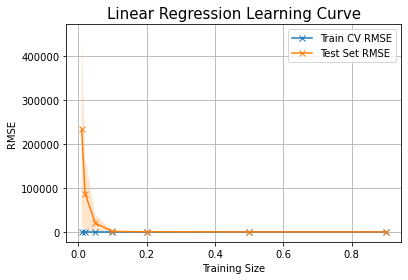

time: 140 ms (started: 2022-10-06 11:20:52 +08:00)


In [49]:
# Plot the train and test score for different train sizes
results_df['train_scores_mean'].plot(style='-x')
results_df['test_scores_mean'].plot(style='-x')

plt.fill_between(results_df.index,\
                 results_df['train_scores_mean']-results_df['train_scores_std'],\
                 results_df['train_scores_mean']+results_df['train_scores_std'],\
                 alpha=0.2)

plt.fill_between(results_df.index,\
                 results_df['test_scores_mean']-results_df['test_scores_std'],\
                 results_df['test_scores_mean']+results_df['test_scores_std'],\
                 alpha=0.2)

plt.grid()
plt.legend(['Train CV RMSE','Test Set RMSE'])
plt.ylabel('RMSE')
plt.xlabel('Training Size')
plt.title('Linear Regression Learning Curve', fontsize=15)
#plt.ylim([0, 1.25]);

In [50]:
y_pred.reshape()

array([0.1540539 , 0.52055371, 0.08710941, ..., 0.06485248, 0.45512464,
       0.19104606])

time: 0 ns (started: 2022-10-06 11:27:07 +08:00)


In [81]:
y_test

22394    0.363591
17935    0.932515
5313     0.041111
20991    0.721436
5172     0.774333
           ...   
12183    0.005098
7074     0.627522
20420    0.159535
3645     0.313441
18286    0.134608
Name: Returns, Length: 5337, dtype: float64

time: 16 ms (started: 2022-10-06 11:42:08 +08:00)


In [92]:
# Draw scatter plot to see if prediction matches actual
# Line of x=y will show perfect prediction
# Also draw the best fit line for the scatter plot

def plotScatter(model_name, x_plot, y_plot, limit):
    
    # Plotting scatter
    plt.scatter(x_plot, y_plot, s=1)
    
    # Drawing a best fit line
    # Reshape the y_test and y_pred arrays
    bestfit = LinearRegression().fit(x_plot.reshape(-1, 1), y_plot.reshape(-1, 1))
    xx = [[-5],[5]]
    yy = bestfit.predict(xx)
    plt.plot(xx, yy, 'g')
    
    # Plot formatting
    plt.grid()
    plt.axhline(y=0, color='r', label='_nolegend_')
    plt.axvline(x=0, color='r', label='_nolegend_')
    plt.xlabel('Actual Return')
    plt.ylabel('Predicted Return')
    plt.plot([-100,100], [-100,100], 'y--')
    plt.xlim([-limit, limit])
    plt.ylim([-limit, limit])
    plt.title(f'Scatter plot for {model_name}')
    plt.legend(['Linear Fit Line', 'y=x Perfect Prediction Line', 'Prediction Points'])

time: 0 ns (started: 2022-10-06 11:48:48 +08:00)


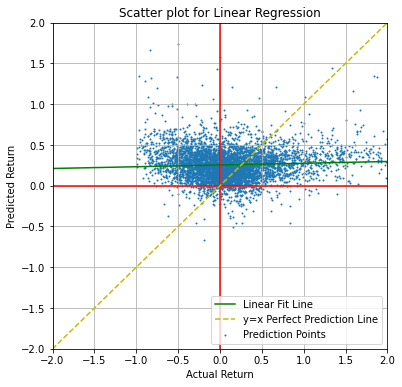

time: 297 ms (started: 2022-10-06 11:48:48 +08:00)


In [93]:
plt.figure(figsize=(6,6))

# need to specify y_test.to_numpy because it is now still in a dataframe, must convert to array
plotScatter('Linear Regression', y_test.to_numpy(), y_pred, 2)

Predictions seemed to be centered around one single value.  We want to take a closer look by taking the top few stock return predictions and comparing them to actual.

In [96]:
def printPredictions(y_test, y_pred):
    # See top 10 predicted annual returns and see how the values differ from actual
    # Put results in a DataFrame so we can sort it.

    y_results = pd.DataFrame()
    y_results['Actual Return'] = y_test
    y_results['Predicted Return'] = y_pred

    # Sort df by the predicted returns.
    y_results.sort_values(by='Predicted Return',
                          ascending=False,
                          inplace=True)

    y_results.reset_index(drop=True, inplace=True)
    
    # Print results
    print('Top Predicted Returns:', \
      list(np.round(y_results['Predicted Return'].iloc[:10],2)))

    print('Comparing Actual Returns:', \
          list(np.round(y_results['Actual Return'].iloc[:10],2)), '\n')

    print('Mean of Top 10 Predicted Returns:', \
          round(y_results['Predicted Return'].iloc[:10].mean(),2) , '%')

    print('Mean of Top 10 Actual Returns:', \
          round(y_results['Actual Return'].iloc[:10].mean(),2) , '%','\n')

    print('Mean of Bottom 10 Predicted Returns:', \
          round(y_results['Predicted Return'].iloc[-10:].mean(),2) , '%')

    print('Mean of Bottom 10 Actual Returns:', \
          round(y_results['Actual Return'].iloc[-10:].mean(),2) , '%','\n')

time: 0 ns (started: 2022-10-06 11:59:48 +08:00)


In [97]:
printPredictions(y_test, y_pred)

Top Predicted Returns: [1.73, 1.66, 1.58, 1.44, 1.43, 1.35, 1.34, 1.33, 1.33, 1.33]
Comparing Actual Returns: [-0.5, -0.84, 0.0, 1.33, -0.04, 1.83, -0.97, 1.88, -0.51, -0.82] 

Mean of Top 10 Predicted Returns: 1.45 %
Mean of Top 10 Actual Returns: 0.14 % 

Mean of Bottom 10 Predicted Returns: -0.45 %
Mean of Bottom 10 Actual Returns: 0.13 % 

time: 0 ns (started: 2022-10-06 11:59:49 +08:00)


## Do a few runs using different random states to see the top/bottom 10 selections and test prediction ability [REDO YOUR CODE HERE]

In [104]:
def testPredictionAbility(pipeline, X, y, nruns):
    '''
    For a given predictor pipeline.
    Create table of top10/bottom 10 averaged, 
    10 rows of 10 random_states.
    to give us a synthetic performance result.    
    Prints Top and Bottom stock picks
    
    The arguments returnSomething=False, verbose=True,
    will be used at the notebook end to get results.
    '''
    
    Top10Pred, Top10Act = [], []
    Bottom10Pred, Bottom10Act = [], []

    for i in range(0, nruns): # Number of runs we want to do
        
        # Train test split with different random states, then fit pipeline and predict
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42+i)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        # Put results in a DataFrame so we can sort it.
        y_results = pd.DataFrame()
        y_results['Actual Return'] = y_test
        y_results['Predicted Return'] = y_pred
        
        # Sort values by the predicted return.
        y_results.sort_values(by='Predicted Return', ascending=False, inplace=True)
        y_results.reset_index(drop=True, inplace=True)
        
        # See top 10 returns and compare how values differ from actual
        Top10Pred.append(round(np.mean(y_results['Predicted Return'].iloc[:10])*100, 2))
        Top10Act.append(round(np.mean(y_results['Actual Return'].iloc[:10])*100, 2))
        
        # See bottom 10 returns and compare how values differ from actual
        Bottom10Pred.append(round(np.mean(y_results['Predicted Return'].iloc[-10:])*100, 2))
        Bottom10Act.append(round(np.mean(y_results['Actual Return'].iloc[-10:])*100, 2))

    # Print out values
    print(f'Predicted Performance of Top 10 Returns ({nruns} runs):', Top10Pred)
    print(f'Actual Performance of Top 10 Returns ({nruns} runs)', Top10Act, '\n')

    print(f'Predicted Performance of Bottom 10 Returns ({nruns} runs):', Bottom10Pred)
    print(f'Actual Performance of Bottom 10 Returns ({nruns} runs):', Bottom10Act)
    print('--------------\n')

#         print('Mean Predicted Std. Dev. of Top 10 Return Portfolios:',
#               round(np.array(Top10PredRtrns).std(),2))
#         print('Mean Actual Std. Dev. of Top 10 Return Portfolios:',
#               round(np.array(Top10ActRtrns).std(),2))
#         print('Mean Predicted Std. Dev. of Bottom 10 Return Portfolios:',
#               round(np.array(Bottom10PredRtrns).std(),2))
#         print('Mean Actual Std. Dev. of Bottom 10 Return Portfolios:',
#               round(np.array(Bottom10ActRtrns).std(),2))
#         print('--------------\n')

    #PERFORMANCE MEASURES HERE
    print(\
    '\033[4mMean Predicted Performance of Top 10 Return Portfolios:\033[0m',\
          round(np.mean(Top10Pred), 2))
    print(\
    '\t\033[4mMean Actual Performance of Top 10 Return Portfolios:\033[0m',\
          round(np.mean(Top10Act), 2))
    print('Mean Predicted Performance of Bottom 10 Return Portfolios:',\
          round(np.mean(Bottom10Pred), 2))
    print('\tMean Actual Performance of Bottom 10 Return Portfolios:',\
          round(np.mean(Bottom10Act), 2))
    print('--------------\n')

    return Top10Act, Bottom10Act

time: 16 ms (started: 2022-10-06 12:33:54 +08:00)


In [105]:
testPredictionAbility(pl, X, y, 10)

Predicted Performance of Top 10 Returns (10 runs): [181.78, 106.65, 132.28, 152.03, 87.86, 140.36, 110.51, 103.1, 124.27, 120.8]
Actual Performance of Top 10 Returns (10 runs) [46.33, 95.62, 52.42, 96.33, 12.2, 68.68, 192.83, 46.93, 60.25, 192.24] 

Predicted Performance of Bottom 10 Returns (10 runs): [-53.68, -40.37, -42.4, -41.56, -31.64, -42.14, -38.88, -43.78, -48.62, -50.78]
Actual Performance of Bottom 10 Returns (10 runs): [13.21, 35.22, 18.75, 20.41, 18.1, 34.46, 12.57, 14.8, 25.5, 21.61]
--------------

Mean Predicted Performance of Top 10 Return Portfolios: 125.96
	Mean Actual Performance of Top 10 Return Portfolios: 86.38
Mean Predicted Performance of Bottom 10 Return Portfolios: -43.39
	Mean Actual Performance of Bottom 10 Return Portfolios: 21.46
--------------



([46.33, 95.62, 52.42, 96.33, 12.2, 68.68, 192.83, 46.93, 60.25, 192.24],
 [13.21, 35.22, 18.75, 20.41, 18.1, 34.46, 12.57, 14.8, 25.5, 21.61])

time: 3.91 s (started: 2022-10-06 12:33:54 +08:00)


# Model 2: ElasticNet

In [24]:
pl2 = Pipeline([
    ('Power Transformer', PowerTransformer()),
    ('ElasticNet', ElasticNet()) #l1_ratio=0.00001, alpha=0.001
])

time: 0 ns (started: 2022-10-06 09:53:02 +08:00)


In [25]:
pl2.fit(X_train, y_train)
y_pred = pl2.predict(X_test)

time: 421 ms (started: 2022-10-06 09:53:02 +08:00)


In [26]:
mse_train = mean_squared_error(y_train, pl2.predict(X_train), squared=True)
mse_test = mean_squared_error(y_test, y_pred, squared=True)
pct_diff = round((1-mse_test/mse_train)*100,3)

print('Train MSE:', mse_train)
print('Test MSE:', mse_test)
print(f'Generalisation: {pct_diff}%')

Train MSE: 1.91420941276543
Test MSE: 0.8889195029055034
Generalisation: 53.562%
time: 15 ms (started: 2022-10-06 09:53:02 +08:00)


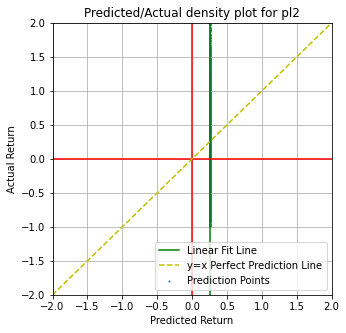

time: 281 ms (started: 2022-10-06 09:53:02 +08:00)


In [27]:
# Predicted/actual density plot for pl_ElasticNet
plt.figure(figsize=(5,5))
plotDensityContourPredVsReal('pl2', y_pred, y_test.to_numpy(),2)

In [28]:
pl_ElasticNet = Pipeline([
    ('Power Transformer', PowerTransformer()),
    ('ElasticNet', ElasticNet(l1_ratio=0.00001))
])

pl_ElasticNet.fit(X_train, y_train)
y_pred_lowL1 = pl_ElasticNet.predict(X_test)

print('train mse: ', mean_squared_error(y_train, pl_ElasticNet.predict(X_train)))
print('test mse: ', mean_squared_error(y_test, pl_ElasticNet.predict(X_test)))

train mse:  1.8861919932600286
test mse:  0.8812011764851028
time: 344 ms (started: 2022-10-06 09:53:02 +08:00)


Text(0.5, 1.0, 'Elasticnet L1 Ratio=0.00001')

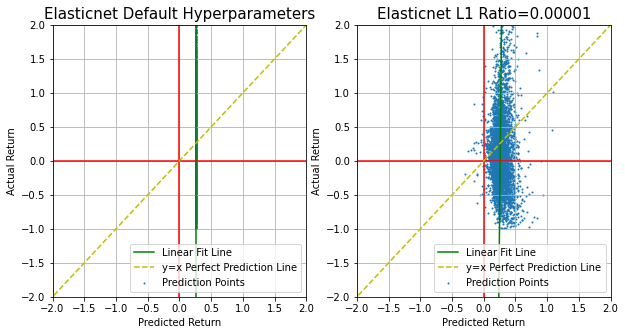

time: 469 ms (started: 2022-10-06 09:53:03 +08:00)


In [29]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plotDensityContourPredVsReal('pl_ElasticNet', y_pred, y_test.to_numpy(),2)
plt.title('Elasticnet Default Hyperparameters',fontsize=15)

plt.subplot(1,2,2)
plotDensityContourPredVsReal('pl_ElasticNet', y_pred_lowL1, y_test.to_numpy(),2)
plt.title('Elasticnet L1 Ratio=0.00001',fontsize=15)

In [30]:
printPredictions(y_test, y_pred)

Predicted Returns: [0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26]
Actual Returns: [0.36, 0.47, 1.59, 0.08, -0.85, 0.19, 0.3, 0.37, -0.51, -0.07] 

Top 10 Predicted Returns: 0.26 %
Actual Top 10 Returns: 0.19 % 

Bottom 10 Predicted Returns: 0.26 %
Actual Bottom 10 Returns: 0.78 % 

time: 15 ms (started: 2022-10-06 09:53:03 +08:00)


In [31]:
observePredictionAbility(pl2, X, y)

Predicted Performance of Top 10 Return Portfolios: [25.35, 25.25, 25.71, 25.27, 24.81, 24.8, 25.5, 25.16, 25.51, 25.47]
Actual Performance of Top 10 Return Portfolios: [63.19, 11.62, -8.68, -28.58, 1.97, 16.92, 10.06, 29.59, 8.15, 38.74] 

Predicted Performance of Bottom 10 Return Portfolios: [25.35, 25.25, 25.71, 25.27, 24.81, 24.8, 25.5, 25.16, 25.51, 25.47]
Actual Performance of Bottom 10 Return Portfolios: [32.81, 13.29, 23.46, 0.32, 32.41, 68.34, -2.84, 10.85, 34.1, 9.05]
--------------

Mean Predicted Std. Dev. of Top 10 Return Portfolios: 0.28
Mean Actual Std. Dev. of Top 10 Return Portfolios: 24.1
Mean Predicted Std. Dev. of Bottom 10 Return Portfolios: 0.28
Mean Actual Std. Dev. of Bottom 10 Return Portfolios: 19.94
--------------

Mean Predicted Performance of Top 10 Return Portfolios: 25.28
	Mean Actual Performance of Top 10 Return Portfolios: 14.3
Mean Predicted Performance of Bottom 10 Return Portfolios: 25.28
	Mean Actual Performance of Bottom 10 Return Portfolios: 22.18


# Model 3: KNN Regressor

In [32]:
pl3 = Pipeline([
    ('Power Transformer', PowerTransformer()),
    ('KNeighborsRegressor', KNeighborsRegressor(n_neighbors=40))])

pl3.fit(X_train, y_train)
y_pred = pl3.predict(X_test)

time: 609 ms (started: 2022-10-06 09:53:07 +08:00)


In [33]:
mse_train = mean_squared_error(y_train, pl2.predict(X_train), squared=True)
mse_test = mean_squared_error(y_test, y_pred, squared=True)
pct_diff = round((1-mse_test/mse_train)*100,3)

print('Train MSE:', mse_train)
print('Test MSE:', mse_test)
print(f'Generalisation: {pct_diff}%')

Train MSE: 1.9142192115489742
Test MSE: 0.8989436692375528
Generalisation: 53.039%
time: 31 ms (started: 2022-10-06 09:53:08 +08:00)


In [34]:
knn_validation_list = []
numNeighbours = [4,8,16,32,64,100]
runNum = 40

for i in numNeighbours:
    print('Trying K='+str(i))
    for j in range(0, runNum):
    #Get a new train/test split
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1,
                                                    random_state=42+j)
        pl_KNeighbors = Pipeline([
            ('Power Transformer', PowerTransformer()),
            ('KNeighborsRegressor', KNeighborsRegressor(n_neighbors=i))
            ]).fit(X_train, y_train)
        
        y_pred = pl_KNeighbors.predict(X_test)
        
        resultThisRun = [i,
            mean_squared_error(y_train, pl_KNeighbors.predict(X_train)),
            mean_squared_error(y_test, y_pred)]
        
        knn_validation_list.append(resultThisRun)

knn_validation_df=pd.DataFrame(knn_validation_list, 
                               columns=['numNeighbours',
                                        'trainError',
                                        'testError'])

Trying K=4
Trying K=8
Trying K=16
Trying K=32
Trying K=64
Trying K=100
time: 4min 59s (started: 2022-10-06 09:53:08 +08:00)


In [35]:
knn_validation_df

,numNeighbours,trainError,testError
0,4,1.027495,1.018749
1,4,1.033132,1.109151
2,4,1.034483,1.003489
3,4,0.993679,1.644268
4,4,0.836608,3.807024
...,...,...,...
235,100,1.669886,1.290499
236,100,1.699216,1.029401
237,100,1.652611,1.456889
238,100,1.536660,2.516476


time: 16 ms (started: 2022-10-06 09:58:07 +08:00)


In [36]:
# Get our results in a format we can easily plot
knn_results_list = []
numNeighboursAttempted = knn_validation_df['numNeighbours'].unique()
results_df = pd.DataFrame(index=numNeighboursAttempted) #Create a DataFrame of results

for i in numNeighboursAttempted:
    
    blNeighbours = knn_validation_df['numNeighbours']==i#boolean mask
    
    trainErrorsMean = knn_validation_df[blNeighbours]['trainError'].mean()
    trainErrorsStd = knn_validation_df[blNeighbours]['trainError'].std()
    testErrorsMean = knn_validation_df[blNeighbours]['testError'].mean()
    testErrorsStd = knn_validation_df[blNeighbours]['testError'].std()
    knn_results_list.append([trainErrorsMean, trainErrorsStd,
                            testErrorsMean, testErrorsStd])
    

knn_results_df = pd.DataFrame(knn_results_list,
                              columns=['train_scores_mean','train_scores_std',
                                       'test_scores_mean','test_scores_std'],
                             index=numNeighboursAttempted)

time: 15 ms (started: 2022-10-06 09:58:07 +08:00)


In [37]:
knn_results_df

,train_scores_mean,train_scores_std,test_scores_mean,test_scores_std
4,0.989514,0.057572,1.647116,0.870546
8,1.272324,0.076496,1.571174,0.883854
16,1.468720,0.090163,1.573731,0.887495
32,1.572841,0.095035,1.572332,0.893758
64,1.621207,0.096546,1.568922,0.887259
100,1.640047,0.096820,1.567977,0.887403


time: 0 ns (started: 2022-10-06 09:58:08 +08:00)


Text(0.5, 1.0, 'KNN Curve Curve')

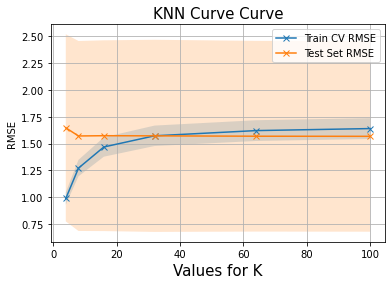

time: 171 ms (started: 2022-10-06 09:58:08 +08:00)


In [38]:
knn_results_df['train_scores_mean'].plot(style='-x')
knn_results_df['test_scores_mean'].plot(style='-x')

plt.fill_between(knn_results_df.index,\
                 knn_results_df['train_scores_mean']-knn_results_df['train_scores_std'],\
                 knn_results_df['train_scores_mean']+knn_results_df['train_scores_std'],\
                 alpha=0.2)

plt.fill_between(knn_results_df.index,\
                 knn_results_df['test_scores_mean']-knn_results_df['test_scores_std'],\
                 knn_results_df['test_scores_mean']+knn_results_df['test_scores_std'],\
                 alpha=0.2)

plt.grid()
plt.legend(['Train CV RMSE','Test Set RMSE'])
plt.ylabel('RMSE')
plt.xlabel('Values for K', fontsize=15)
plt.title('KNN Curve Curve', fontsize=15)
#plt.ylim([0, 1.25]);

In [39]:
pplt.figure(figsize=(6,6))
plotDensityContourPredVsReal('pl_KNeighbors', y_pred, y_test.to_numpy(),2)

NameError: name 'pplt' is not defined

time: 250 ms (started: 2022-10-06 09:58:08 +08:00)


In [ ]:
printPredictions(y_test, y_pred)

In [ ]:
observePredictionAbility(pl3, X, y)